# Predecir nivel de adaptabilidad

In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder

print(tf.__version__)

2023-11-22 00:56:23.322493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 00:56:23.359125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 00:56:23.359165: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 00:56:23.359201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 00:56:23.366779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 00:56:23.367409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

2.14.0


## Exploracion de los datos
The data is obtained from the csv file "training-ds"

In [2]:
raw_dataset = pd.read_csv("./training-ds.csv")
dataset = raw_dataset.copy()
raw_dataset.head()


,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-Jun,Bajo
1,3G,No,Escuela,Si,Privado,Nov-15,Smartphone,Compra Megas,Media,Femenino,01-Mar,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-Mar,Bajo
3,3G,Si,Escuela,Si,Privado,Nov-15,Smartphone,Compra Megas,Media,Masculino,01-Mar,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-Mar,Alto


### Cleaning Data

If the dataset contains any unknown value the row containing it will be deleted

In [3]:
dataset.isna().sum()

Tipo de Red                 0
Estudiante de Tecnología    0
Nivel de Educación          0
Vive en Ciudad              0
Tipo de Instituto           0
Edad                        0
Dispositivo                 0
Tipo de Internet            0
Situación Financiera        0
Género                      0
Duración de la Clase        0
Nivel de Adaptación         0
dtype: int64

As the dataset does not contain any unknown values, no row will be deleted.

### Correcting the data
The "Edad" column should contain values that indicate an age interval following this format: "21-24". 
But there are values that changed the value of a limit for a month like this: "Nov-15"

The data is corrected using the "correct_age" function.

In [4]:
def correct_number(edad): 
    months = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
             'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

    for m in months: 
        if m in edad: 
            return edad.replace(m, months[m]) 
        
    return edad

This function is applied to the "Edad" column.

In [5]:
dataset['Edad'] = dataset["Edad"].apply(correct_number)
dataset.head()

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-Jun,Bajo
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,01-Mar,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-Mar,Bajo
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,01-Mar,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-Mar,Alto


Same as the "Edad" column the "Duracion de la clase" column has the number values changed. 
The same function is applied to this column

In [6]:
dataset['Duración de la Clase'] = dataset["Duración de la Clase"].apply(correct_number)
dataset.head()

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-06,Bajo
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,01-03,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-03,Bajo
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,01-03,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-03,Alto


### One hot encoding

In [7]:
#Tipo de red
dataset['Tipo de Red'].nunique()

3

In [8]:
def one_hot_encoding(colum, val):
    lst =[]
    for elem in dataset[colum]:
        if(elem == val):
            lst.append(1)
        else:
            lst.append(0)
    return lst

In [9]:
# four_g=one_hot_encoding('Tipo de Red','4G')
# three_g=one_hot_encoding('Tipo de Red','3G')
# two_g=one_hot_encoding('Tipo de Red','2G')

In [10]:
# dataset.insert(1, "G4", four_g, True)
# dataset.insert(1, "G3", three_g, True)
# dataset.insert(1, "G2", two_g, True)
# dataset.drop(columns=['Tipo de Red'])
#dataset['Estudiante de Tecnología'].unique()

In [11]:
dataset.columns.values

array(['Tipo de Red', 'Estudiante de Tecnología', 'Nivel de Educación',
       'Vive en Ciudad', 'Tipo de Instituto', 'Edad', 'Dispositivo',
       'Tipo de Internet', 'Situación Financiera', 'Género',
       'Duración de la Clase', 'Nivel de Adaptación'], dtype=object)

In [12]:
def hot_one_dataset(dataset):
    new_dataset=pd.DataFrame()
    for i in dataset.columns.values:
        if(len(dataset[i].unique())>2):
            for j in dataset[i].unique():
                new_dataset.insert(0, str(i+" "+j), one_hot_encoding(i, j), True)
        else:
            new_dataset.insert(0, str(i), one_hot_encoding(i, dataset[i].unique()[0]), True)
    return new_dataset

In [13]:
# tags=dataset.pop('Nivel de Adaptación')
encoded_dataset=hot_one_dataset(dataset)
encoded_dataset

,Nivel de Adaptación Alto,Nivel de Adaptación Moderado,Nivel de Adaptación Bajo,Duración de la Clase 0,Duración de la Clase 01-03,Duración de la Clase 03-06,Género,Situación Financiera Buena,Situación Financiera Mala,Situación Financiera Media,...,Edad 21-25,Tipo de Instituto,Vive en Ciudad,Nivel de Educación Colegio,Nivel de Educación Escuela,Nivel de Educación Universidad,Estudiante de Tecnología,Tipo de Red 2G,Tipo de Red 4G,Tipo de Red 3G
0,0,0,1,0,0,1,1,0,0,1,...,1,1,1,0,0,1,1,0,0,1
1,0,1,0,0,1,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,1
2,0,0,1,0,1,0,1,0,1,0,...,1,1,1,0,0,1,1,0,0,1
3,0,1,0,0,1,0,1,0,0,1,...,0,1,1,0,1,0,1,0,0,1
4,1,0,0,0,1,0,1,1,0,0,...,1,1,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,0,1,0,0,1,0,1,0,0,1,...,1,1,1,0,0,1,0,0,0,1
960,0,1,0,0,1,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,1
961,0,0,1,1,0,0,1,0,0,1,...,1,0,1,0,0,1,0,0,1,0
962,0,1,0,0,1,0,1,0,0,1,...,1,1,1,0,0,1,0,0,0,1


In [14]:
encoded_dataset.columns.values

array(['Nivel de Adaptación Alto', 'Nivel de Adaptación Moderado',
       'Nivel de Adaptación Bajo', 'Duración de la Clase 0',
       'Duración de la Clase 01-03', 'Duración de la Clase 03-06',
       'Género', 'Situación Financiera Buena',
       'Situación Financiera Mala', 'Situación Financiera Media',
       'Tipo de Internet', 'Dispositivo Tableta',
       'Dispositivo Smartphone', 'Dispositivo Computadora', 'Edad 06-10',
       'Edad 01-05', 'Edad 26-30', 'Edad 16-20', 'Edad 11-15',
       'Edad 21-25', 'Tipo de Instituto', 'Vive en Ciudad',
       'Nivel de Educación Colegio', 'Nivel de Educación Escuela',
       'Nivel de Educación Universidad', 'Estudiante de Tecnología',
       'Tipo de Red 2G', 'Tipo de Red 4G', 'Tipo de Red 3G'], dtype=object)

In [15]:
def plot_pies(dataset):
    display=len(dataset.columns.values)
    fig, axes = plt.subplots(3,4,figsize=(10, 10))
    fig.subplots_adjust(wspace=.5)
    counter=0
    x=(0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2)
    z=(0, 1, 2, 3, 0, 1, 2, 3, 0, 1 ,2 ,3)
    for i in dataset.columns.values:
            val1=x[counter]
            val2=z[counter]
            y=dataset.pivot_table(index = [i], aggfunc ='size')
            axes[val1][val2].pie(y, labels =list(y.keys()))
            axes[val1][val2].set_title(i, fontsize = 12)
            counter=counter+1
    plt.show()

# for i, (idx, row) in enumerate(table.head(8).iterrows()):
#     ax = axes[i // 3, i % 3]
#     row = row[row.gt(row.sum() * .01)]
#     ax.pie(row, 
#            labels=row.values, 
#            startangle=30, 
#            wedgeprops=dict(width=.5), # For donuts
#            colors=colors, 
#            textprops={'color':font_color})
#     ax.set_title(idx, fontsize=16, color=font_color)
    
#     legend = plt.legend([x[1] for x in row.index], 
#                         bbox_to_anchor=(1.3, .87), # Legend position
#                         loc='upper left',  
#                         ncol=1, 
#                         fancybox=True)
#     for text in legend.get_texts():
#         plt.setp(text, color=font_color) # Legend font color

# fig.subplots_adjust(wspace=.2) # Space between charts

# title = fig.suptitle('Categories of crime in London boroughs', y=.95, fontsize=20, color=font_color)
# # To prevent the title from being cropped
# plt.subplots_adjust(top=0.85, bottom=0.15)

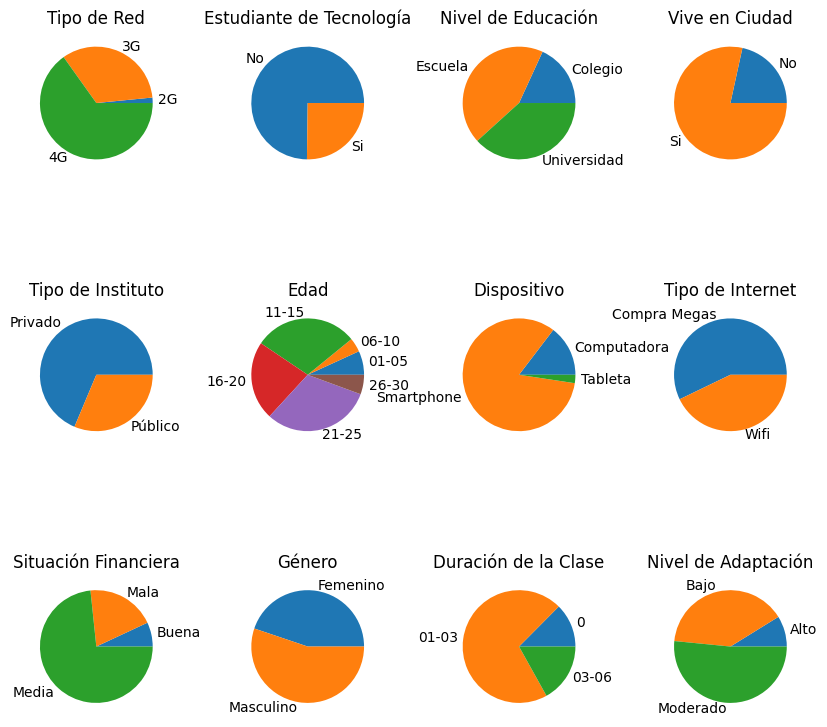

In [16]:
#encoded_dataset.plot.pie(y='Género', figsize=(5, 5))

plot_pies(dataset)

In [17]:
dataset.pivot_table(index = ['Tipo de Instituto'], aggfunc ='size')

Tipo de Instituto
Privado    662
Público    302
dtype: int64

In [18]:
correlation_matrix = encoded_dataset.corr()
correlations = correlation_matrix.loc[['Nivel de Adaptación Alto', "Nivel de Adaptación Moderado", "Nivel de Adaptación Bajo"]]
correlations = correlations.transpose()
correlations = correlations.drop(['Nivel de Adaptación Alto', "Nivel de Adaptación Moderado", "Nivel de Adaptación Bajo"])
correlations

,Nivel de Adaptación Alto,Nivel de Adaptación Moderado,Nivel de Adaptación Bajo
Duración de la Clase 0,-0.117813,-0.334453,0.410024
Duración de la Clase 01-03,0.072560,0.106634,-0.151017
Duración de la Clase 03-06,0.015886,0.165930,-0.178748
Género,0.103664,0.003014,-0.063174
Situación Financiera Buena,0.389750,-0.069726,-0.154700
Situación Financiera Mala,0.011467,-0.130219,0.126404
Situación Financiera Media,-0.234469,0.157252,-0.024748
Tipo de Internet,0.122606,-0.020664,-0.049963
Dispositivo Tableta,-0.024644,0.124345,-0.112763
Dispositivo Smartphone,-0.122091,-0.090864,0.163617


In [19]:
correlations['mean'] = correlations[['Nivel de Adaptación Alto', "Nivel de Adaptación Moderado", "Nivel de Adaptación Bajo"]].abs().mean(axis=1)
correlations = correlations[correlations['mean'] >= 0.10]
correlations

,Nivel de Adaptación Alto,Nivel de Adaptación Moderado,Nivel de Adaptación Bajo,mean
Duración de la Clase 0,-0.117813,-0.334453,0.410024,0.287430
Duración de la Clase 01-03,0.072560,0.106634,-0.151017,0.110071
Duración de la Clase 03-06,0.015886,0.165930,-0.178748,0.120188
Situación Financiera Buena,0.389750,-0.069726,-0.154700,0.204725
Situación Financiera Media,-0.234469,0.157252,-0.024748,0.138823
Dispositivo Smartphone,-0.122091,-0.090864,0.163617,0.125524
Dispositivo Computadora,0.140463,0.042915,-0.125276,0.102885
Edad 06-10,0.158966,-0.148617,0.059694,0.122426
Edad 01-05,-0.084304,0.139505,-0.093667,0.105825
Edad 16-20,-0.124376,-0.071411,0.145066,0.113618


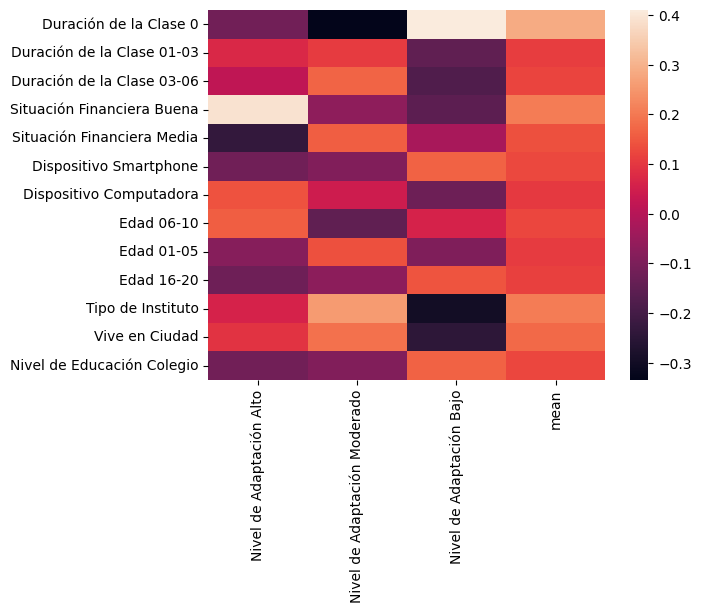

In [20]:

sns.heatmap(correlations, annot=False)
plt.show()

# Models

# Training